## Importing all the necessary Libraries

In [ ]:
# Listing all the required imports in this cell

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from llava.conversation import conv_templates, SeparatorStyle
from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
from llava.utils import disable_torch_init
from transformers import TextStreamer
import matplotlib.pyplot as plt
from ast import keyword
from io import BytesIO
from PIL import Image, ImageDraw
import numpy as np
import requests
import torch
import cv2
import os

[2024-12-13 14:26:56,166] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


## LLaVA MODEL

In [ ]:
model_directory = "4bit/llava-v1.5-13b-3GB"
model_config = {
    "device_map": "auto",
    "load_in_4bit": True,
    "quantization_config": BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type='nf4'
    )
}

In [ ]:
llava_model = LlavaLlamaForCausalLM.from_pretrained(model_directory, low_cpu_mem_usage=True, **model_config)
auto_tokenizer = AutoTokenizer.from_pretrained(model_directory, use_fast=False)
vision_module = llava_model.get_vision_tower()
if not vision_module.is_loaded:
    vision_module.load_model()
vision_module.to(device='cuda')
image_processor = vision_module.image_processor


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00009.bin:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00009.bin:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00004-of-00009.bin:   0%|          | 0.00/2.96G [00:00<?, ?B/s]

pytorch_model-00005-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00006-of-00009.bin:   0%|          | 0.00/2.98G [00:00<?, ?B/s]

pytorch_model-00007-of-00009.bin:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

pytorch_model-00008-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00009-of-00009.bin:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

## Loading Dataset

In [ ]:
import os

file_path = 'dataset.zip'
if os.path.isfile(file_path):
    print('File already exists! Delete the file to force download again...')
else:
    os.system("LC_ALL=C.UTF-8 wget --no-check-certificate -O dataset.zip 'https://drive.google.com/uc?id=1NwF_1cN5pdc3KGDIqBwYed3ZkF-xatx2'")
    os.system('unzip dataset.zip -d dataset')


# Defining all the necessary functions

In [ ]:
def generate_caption(image_path, prompt_text):
    """
    Generates a caption or instructions for an image using a pre-trained LLaVA model.

    Args:
        image_path (str): Path or URL to the image.
        prompt_text (str): Text prompt to guide the model's output.

    Returns:
        PIL.Image: Processed image.
        str: Model output text.
    """

    # Checking if the image path is a URL or a local file, if a URL, then
    # downloading it and loading it as an RGB image
    if image_path.startswith('http'):
        response = requests.get(image_path)
        input_image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        input_image = Image.open(image_path).convert('RGB')

    # Disbaling if there are any default initializations for PyTorch
    disable_torch_init()

    # Defining the conversation mode and getting the roles.
    conversation_mode = "llava_v0"
    conversation = conv_templates[conversation_mode].copy()
    roles = conversation.roles

    # Preprocessing the input image and prepare the input text prompt format
    image_tensor = image_processor.preprocess(input_image, return_tensors='pt')['pixel_values'].half().cuda()
    input_prompt = f"{roles[0]}: {prompt_text}"
    input_prompt = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + input_prompt

    # Appending the conversation messages to the model's input
    conversation.append_message(conversation.roles[0], input_prompt)
    conversation.append_message(conversation.roles[1], None)

    # Getting the full conversation prompt as input and tokenizing the conversation prompt
    raw_conversation_prompt = conversation.get_prompt()
    input_ids = tokenizer_image_token(raw_conversation_prompt, auto_tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    # Defining the stopping criteria for the model to stop generating output
    # When a special token is detected
    stop_sequence = conversation.sep if conversation.sep_style != SeparatorStyle.TWO else conversation.sep2
    stopping_criteria = KeywordsStoppingCriteria([stop_sequence], auto_tokenizer, input_ids)

    # Performing inference with the LLaVA model
    with torch.inference_mode():
        output_ids = llava_model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True, # Enabling sampling for randomness
            temperature=0.2, # Sampling temperature to control the randomness
            max_new_tokens=1024, # Maximum number of tokens the model can generate
            use_cache=True,
            stopping_criteria=[stopping_criteria] # Applying the stopping criteria to end generation
        )

    # Decoding the output text, updating the conversation with the generated text and
    # Cleaning the output text by removing any unwanted ending tokens.
    generated_text = auto_tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conversation.messages[-1][-1] = generated_text
    clean_output = generated_text.rsplit('</s>', 1)[0]

    return input_image, clean_output

from PIL import ImageDraw
def add_bounding_box(input_image, box_coordinates, outline_color="red", line_width=3):
    """
    Draws a bounding box on the given image.

    Args:
        input_image (PIL.Image): The image on which to draw the bounding box.
        box_coordinates (list): List of fractional coordinates [x_min, y_min, x_max, y_max].
        outline_color (str): Color of the bounding box.
        line_width (int): Width of the bounding box lines.

    Returns:
        PIL.Image: Image with the bounding box drawn.
    """

    # getting the dimensions of the input image and converting the fractional coordinates
    # as absolute pixel values
    img_width, img_height = input_image.size
    x_start = int(box_coordinates[0] * img_width)
    y_start = int(box_coordinates[1] * img_height)
    x_end = int(box_coordinates[2] * img_width)
    y_end = int(box_coordinates[3] * img_height)

    drawer = ImageDraw.Draw(input_image)
    drawer.rectangle([x_start, y_start, x_end, y_end], outline=outline_color, width=line_width)

    return input_image

In [ ]:
def generate_image_with_bounding_box(image_path, prompt):
    """
    Generates an image with a bounding box based on the given prompt.

    Parameters:
        image_path (str): The path to the image file.
        prompt (str): The text prompt to process and generate the bounding box.

    Returns:
        PIL.Image.Image: The image with the bounding box drawn.
    """
    image, model_output = generate_caption(image_path, prompt)
    print(f'Model Output: {model_output}')
    bounding_box = eval(model_output) # Bounding Box Coordinates
    image_with_box = add_bounding_box(image.copy(), bounding_box)
    print(f'Text Prompt: {prompt}')
    return image_with_box

## BASIC TASK Results:

Generating Bounding Box Coordinates and Visualizing the bounding box by drawing it on an image

Model Output: [0.65, 0.16, 0.88, 0.44]
Text Prompt: Give exact coordinates to place an apple in the image


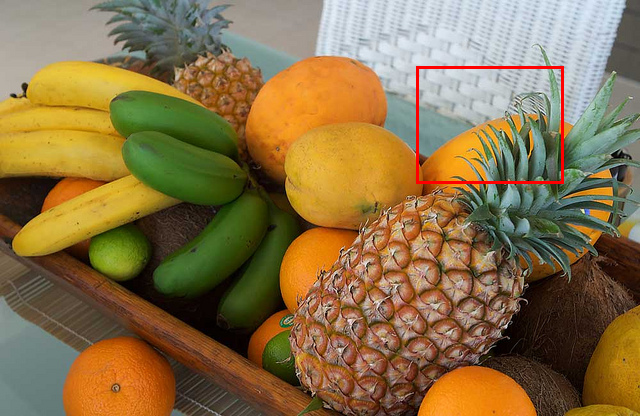

In [ ]:
# Result I
image_path = '/dataset/scene_images/10403.jpg'
prompt = 'Give exact coordinates to place an apple in the image'
result_image = generate_image_with_bounding_box(image_path, prompt)
result_image


Model Output: [0.39, 0.13, 0.85, 0.43]
Text Prompt: Give exact coordinates to place a banana in the image


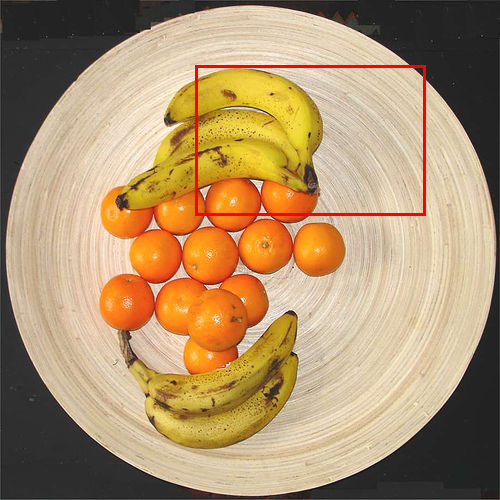

In [ ]:
# Result II
image_path = '/dataset/scene_images/265713.jpg'
prompt = 'Give exact coordinates to place a banana in the image'
result_image = generate_image_with_bounding_box(image_path, prompt)
result_image

Model Output: [0.76, 0.41, 0.99, 0.89]
Text Prompt: Give exact coordinates to place a broccoli in the image


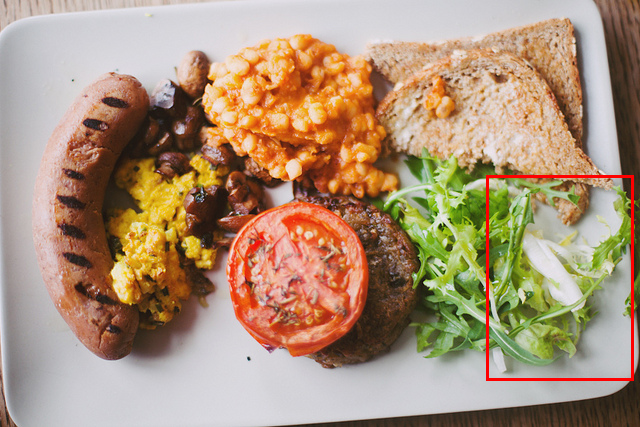

In [ ]:
# Result III
image_path = '/dataset/scene_images/177877.jpg'
prompt = 'Give exact coordinates to place a broccoli in the image'
result_image = generate_image_with_bounding_box(image_path, prompt)
result_image

Model Output: [0.0, 0.63, 0.99, 0.74]
Text Prompt: Give exact coordinates to place a bus in the image


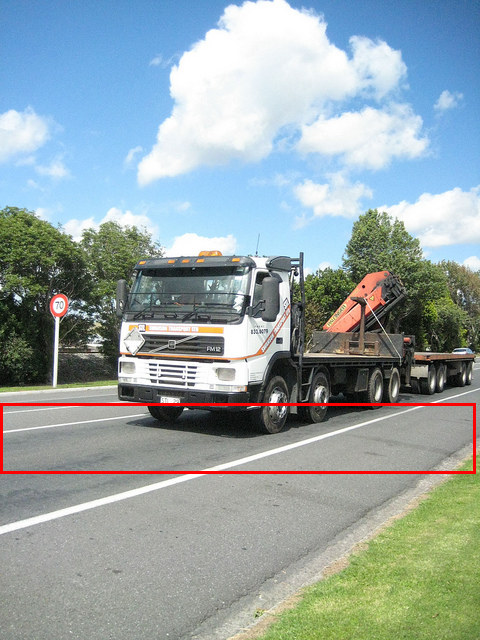

In [ ]:
# Result IV
image_path = '/dataset/scene_images/67463.jpg'
prompt = 'Give exact coordinates to place a bus in the image'
result_image = generate_image_with_bounding_box(image_path, prompt)
result_image

Model Output: [0.61, 0.09, 0.99, 0.59]
Text Prompt: Give exact coordinates to place mobile in the image


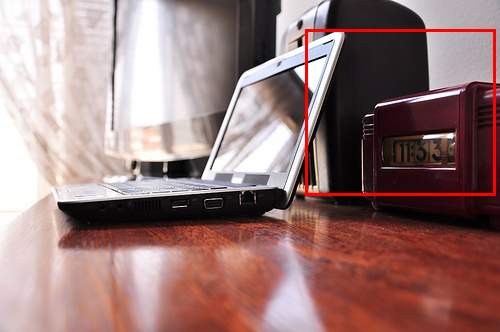

In [ ]:
# Result V
image_path = '/dataset/scene_images/76896.jpg'
prompt = 'Give exact coordinates to place mobile in the image'
result_image = generate_image_with_bounding_box(image_path, prompt)
result_image

Model Output: [0.77, 0.42, 0.99, 0.7]
Text Prompt: Give exact coordinates to place a donut in the image


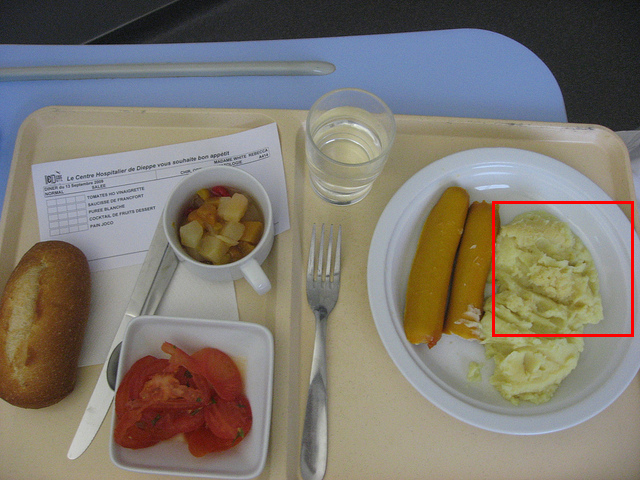

In [ ]:
# Result VI
image_path = '/dataset/scene_images/181030.jpg'
prompt = 'Give exact coordinates to place a donut in the image'
result_image = generate_image_with_bounding_box(image_path, prompt)
result_image

## END of the Basic Task